In [1]:
import os
import sys
import glob
import scipy
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_rows', 100)
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_columns', 100)

sns.set_palette("Set2")


# Load IgA data

In [2]:
dataloc = '/LAB_DATA/CURRENT/CURRENT_Metagenomics_PROJECTS/2021_IgASeq/tables/'

FIGdb = pd.read_csv(dataloc + 'SupplementalTable_S2_v1.csv')
FIGdb['order'] = [x.split(';')[3].split('__')[-1] for x in FIGdb['GTDB_r202']]
FIGdb


,genome,Tube_ID,positive_breadth,positive_rel_ab,positive_coverage,positive_sample,unsorted_breadth,unsorted_rel_ab,unsorted_coverage,unsorted_sample,GTDB_r202,name,phylum,class,family,genus,species,IgA_frac,pass_soring_QC,IgA_prob,semi_robustly_detected,robustly_detected,IgA_binding_class,group,order
0,GUT_GENOME000139.fna.fa,7028,0.552788,0.000369,1.121264,OS_61,0.000000,0.000000,0.000000,OS_23,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,Blautia_A hydrogenotrophica,Firmicutes_A,Clostridia,Lachnospiraceae,Blautia_A,Blautia_A hydrogenotrophica,0.0767,True,1000000.000000,True,False,high,Fermented,Lachnospirales
1,GUT_GENOME000767.fna.fa,7028,0.826847,0.000752,2.513575,OS_61,0.000000,0.000000,0.000000,OS_23,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,Sellimonas intestinalis,Firmicutes_A,Clostridia,Lachnospiraceae,Sellimonas,Sellimonas intestinalis,0.0767,True,1000000.000000,True,False,high,Fermented,Lachnospirales
2,GUT_GENOME094675.fna.fa,7028,0.917889,0.001756,6.808159,OS_61,0.922662,0.002606,13.991979,OS_23,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,UMGS1370 sp900542035,Firmicutes_A,Clostridia,Lachnospiraceae,UMGS1370,UMGS1370 sp900542035,0.0767,True,0.051674,True,True,low,Fermented,Lachnospirales
3,GUT_GENOME096206.fna.fa,7028,0.367780,0.000285,0.943784,OS_61,0.622296,0.000365,1.669483,OS_23,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,Schaedlerella glycyrrhizinilytica,Firmicutes_A,Clostridia,Lachnospiraceae,Schaedlerella,Schaedlerella glycyrrhizinilytica,0.0767,True,0.059958,True,False,low,Fermented,Lachnospirales
4,GUT_GENOME096538.fna.fa,7028,0.582794,0.000457,1.439149,OS_61,0.720518,0.000549,2.368276,OS_23,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,Enterocloster sp001517625,Firmicutes_A,Clostridia,Lachnospiraceae,Enterocloster,Enterocloster sp001517625,0.0767,True,0.063900,True,True,low,Fermented,Lachnospirales
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,8038,0.000000,0.000000,0.000000,OS_43,0.706145,0.000370,1.926473,OS_5,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,Ruthenibacterium sp900759375,Firmicutes_A,Clostridia,Ruminococcaceae,Ruthenibacterium,Ruthenibacterium sp900759375,0.0860,True,0.000000,True,False,uncoated,Fiber,Oscillospirales
3515,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,8038,0.000000,0.000000,0.000000,OS_43,0.910379,0.000878,4.739497,OS_5,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,Lawsonibacter asaccharolyticus,Firmicutes_A,Clostridia,Oscillospiraceae,Lawsonibacter,Lawsonibacter asaccharolyticus,0.0860,True,0.000000,True,False,uncoated,Fiber,Oscillospirales
3516,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,8038,0.000000,0.000000,0.000000,OS_43,0.918784,0.000405,3.630133,OS_5,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__T...,CAG-269 sp900760175,Firmicutes_A,Clostridia,CAG-508,CAG-269,CAG-269 sp900760175,0.0860,True,0.000000,True,False,uncoated,Fiber,TANB77
3517,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,8038,0.000000,0.000000,0.000000,OS_43,0.919023,0.000955,4.243006,OS_5,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,Pygmaiobacter sp.,Firmicutes_A,Clostridia,Ruminococcaceae,Pygmaiobacter,unk,0.0860,True,0.000000,True,False,uncoated,Fiber,Oscillospirales


## Make ML table for taxonomy

In [3]:
MLdb = FIGdb[['genome', 'Tube_ID', 'IgA_binding_class', 'phylum', 'class', 'order', 'family', 'genus', 'species']]
MLdb


,genome,Tube_ID,IgA_binding_class,phylum,class,order,family,genus,species
0,GUT_GENOME000139.fna.fa,7028,high,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Blautia_A,Blautia_A hydrogenotrophica
1,GUT_GENOME000767.fna.fa,7028,high,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Sellimonas,Sellimonas intestinalis
2,GUT_GENOME094675.fna.fa,7028,low,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,UMGS1370,UMGS1370 sp900542035
3,GUT_GENOME096206.fna.fa,7028,low,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Schaedlerella,Schaedlerella glycyrrhizinilytica
4,GUT_GENOME096538.fna.fa,7028,low,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Enterocloster,Enterocloster sp001517625
...,...,...,...,...,...,...,...,...,...
3514,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,8038,uncoated,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Ruthenibacterium,Ruthenibacterium sp900759375
3515,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,8038,uncoated,Firmicutes_A,Clostridia,Oscillospirales,Oscillospiraceae,Lawsonibacter,Lawsonibacter asaccharolyticus
3516,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,8038,uncoated,Firmicutes_A,Clostridia,TANB77,CAG-508,CAG-269,CAG-269 sp900760175
3517,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,8038,uncoated,Firmicutes_A,Clostridia,Oscillospirales,Ruminococcaceae,Pygmaiobacter,unk


## Make a table for the genes

In [5]:
POdb = pd.read_csv(dataloc + 'SupplementalTable_S7_v1.csv.gz', dtype={'genes':int, 'bases':int})

s2s1 = FIGdb.set_index('positive_sample')['Tube_ID'].to_dict()
s2s2 = FIGdb.set_index('unsorted_sample')['Tube_ID'].to_dict()
s2s = {**s2s1, **s2s2}

POdb['Tube_ID'] = POdb['sample'].map(s2s)
POdb = POdb[~POdb['Tube_ID'].isna()]
POdb['Tube_ID'] = POdb['Tube_ID'].astype(int).astype(str)

POdb['unique_id'] = POdb['genome'] + '|||' + POdb['Tube_ID']

# Pivot the table to get anno as columns and fill missing values with 0
pivot_df = POdb.pivot_table(values='genes', index='unique_id', columns='anno', fill_value=0, aggfunc='sum')

# Convert all positive integers to 1 (presence) and keep 0 as absence
pivot_df = (pivot_df > 0).astype(int)
pivot_df = pivot_df.reset_index(drop=False)

xdb = FIGdb[['genome', 'Tube_ID', 'IgA_binding_class']]
xdb['Tube_ID'] = xdb['Tube_ID'].astype(str)
xdb['unique_id'] = xdb['genome'] + '|||' + xdb['Tube_ID']

MLGdb  = pd.merge(pivot_df, xdb, how='inner', on=['unique_id'])
MLGdb


/tmp/ipykernel_630097/228343904.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdb['Tube_ID'] = xdb['Tube_ID'].astype(str)
/tmp/ipykernel_630097/228343904.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdb['unique_id'] = xdb['genome'] + '|||' + xdb['Tube_ID']


,unique_id,1-cysPrx_C,12TM_1,2-Hacid_dh,2-Hacid_dh_C,2-oxoacid_dh,2-oxogl_dehyd_N,2-ph_phosp,23S_rRNA_IVP,2CSK_N,2Fe-2S_thioredx,2H-phosphodiest,2HCT,2OG-FeII_Oxy,2OG-FeII_Oxy_2,2OG-FeII_Oxy_3,2OG-Fe_Oxy_2,2TM,2_5_RNA_ligase2,3-HAO,3-alpha,3-dmu-9_3-mt,3000005,3000010,3000013,3000024,3000025,3000026,3000027,3000074,3000090,3000118,3000124,3000165,3000166,3000167,3000168,3000173,3000175,3000177,3000179,3000180,3000181,3000182,3000183,3000186,3000190,3000191,3000192,3000193,...,tRNA_int_endo_N,tRNA_m1G_MT,tRNA_synt_2f,tRNA_synthFbeta,ubiquitin,vATP-synt_AC39,vATP-synt_E,vWA-TerF-like,vWF_A,ydhR,zf-ACC,zf-C2H2_6,zf-C4_ClpX,zf-C4_Topoisom,zf-CCCH_2,zf-CCHC,zf-CDGSH,zf-CHC2,zf-CHCC,zf-CHY,zf-Di19,zf-FPG_IleRS,zf-HC2,zf-HYPF,zf-IS66,zf-ISL3,zf-MYND,zf-NADH-PPase,zf-RING_7,zf-RRN7,zf-RanBP,zf-Sec23_Sec24,zf-TFIIB,zf-TRM13_CCCH,zf-ZPR1,zf-dskA_traR,zf-like,zf-ribbon_3,zf-trcl,zf_CopZ,zinc-ribbons_6,zinc_ribbon_13,zinc_ribbon_15,zinc_ribbon_2,zinc_ribbon_4,zinc_ribbon_5,zn-ribbon_14,genome,Tube_ID,IgA_binding_class
0,GUT_GENOME000035.fna.fa|||1036,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,GUT_GENOME000035.fna.fa,1036,uncoated
1,GUT_GENOME000035.fna.fa|||7033,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,GUT_GENOME000035.fna.fa,7033,uncoated
2,GUT_GENOME000035.fna.fa|||8018,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,GUT_GENOME000035.fna.fa,8018,low
3,GUT_GENOME000094.fna.fa|||7029,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GUT_GENOME000094.fna.fa,7029,high
4,GUT_GENOME000094.fna.fa|||7040,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,1,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,GUT_GENOME000094.fna.fa,7040,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,7041,uncoated
3515,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,8030,uncoated
3516,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,8038,low
3517,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,1041,lo

# Delcare methods

In [20]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.preprocessing import OneHotEncoder, label_binarize
from itertools import cycle

# Function to one-hot encode the taxonomy columns
def one_hot_encode(df, columns):
    return pd.get_dummies(df, columns=columns)

# Function to handle class imbalance
def handle_class_imbalance(X, y, method='undersample', verbose=False, random_state=42):
    if verbose:
        print(f'Original dataset shape {Counter(y)}')
    if method == 'undersample':
        rus = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X, y)
    elif method == 'oversample':
        smote = SMOTE(random_state=random_state)
        F, y_resampled = smote.fit_resample(X, y)
    if verbose:
        print(f'Final dataset shape {Counter(y_resampled)}')
    return X_resampled, y_resampled

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_percentage = cm_normalized * 100
    
    print(cm_percentage)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #plt.show()

    
def plot_roc_curve(y_test, y_score, classes):
    if len(classes) == 2:
        # Identify the positive class label. Replace 'high' with whichever label you consider as positive.
        pos_label = 'uncoated'
        
        # Convert y_test to binary labels where the positive class is represented as 1 and the other as 0.
        y_test_bin = (y_test == pos_label).astype(int)
        
        fpr, tpr, _ = roc_curve(y_test_bin, y_score[:, 1], pos_label=1)  # Assuming the second column is for the positive class
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        #plt.show()
        return

    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = y_test_bin.shape[1]
    fpr, tpr, roc_auc = {}, {}, {}

    for i, label in enumerate(classes):  # Note the change here to enumerate classes
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')  # Note the change here to use class labels

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    #plt.show()
    

## Test gene classifier

,1-cysPrx_C,12TM_1,2-Hacid_dh,2-Hacid_dh_C,2-oxoacid_dh,2-oxogl_dehyd_N,2-ph_phosp,23S_rRNA_IVP,2CSK_N,2Fe-2S_thioredx,2H-phosphodiest,2HCT,2OG-FeII_Oxy,2OG-FeII_Oxy_2,2OG-FeII_Oxy_3,2OG-Fe_Oxy_2,2TM,2_5_RNA_ligase2,3-HAO,3-alpha,3-dmu-9_3-mt,3000005,3000010,3000013,3000024,3000025,3000026,3000027,3000074,3000090,3000118,3000124,3000165,3000166,3000167,3000168,3000173,3000175,3000177,3000179,3000180,3000181,3000182,3000183,3000186,3000190,3000191,3000192,3000193,3000194,...,tRNA_deacylase,tRNA_edit,tRNA_int_endo,tRNA_int_endo_N,tRNA_m1G_MT,tRNA_synt_2f,tRNA_synthFbeta,ubiquitin,vATP-synt_AC39,vATP-synt_E,vWA-TerF-like,vWF_A,ydhR,zf-ACC,zf-C2H2_6,zf-C4_ClpX,zf-C4_Topoisom,zf-CCCH_2,zf-CCHC,zf-CDGSH,zf-CHC2,zf-CHCC,zf-CHY,zf-Di19,zf-FPG_IleRS,zf-HC2,zf-HYPF,zf-IS66,zf-ISL3,zf-MYND,zf-NADH-PPase,zf-RING_7,zf-RRN7,zf-RanBP,zf-Sec23_Sec24,zf-TFIIB,zf-TRM13_CCCH,zf-ZPR1,zf-dskA_traR,zf-like,zf-ribbon_3,zf-trcl,zf_CopZ,zinc-ribbons_6,zinc_ribbon_13,zinc_ribbon_15,zinc_ribbon_2,zinc_ribbon_4,zinc_ribbon_5,zn-ribbon_14
0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,...,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,...,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,1,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Model accuracy: 0.6243386243386243
[[69.62962963 17.77777778 12.59259259]
 [18.51851852 52.77777778 28.7037037 ]
 [ 7.40740741 29.62962963 62.96296296]]


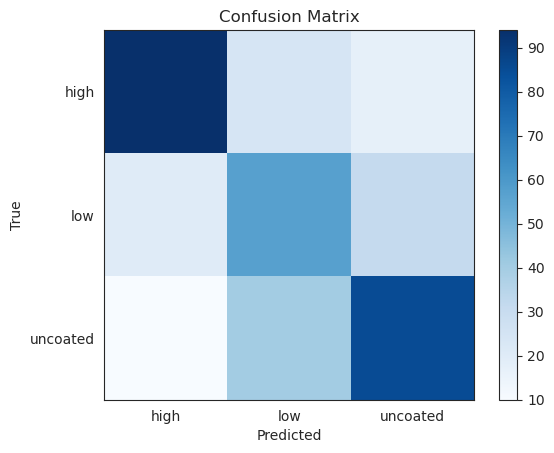

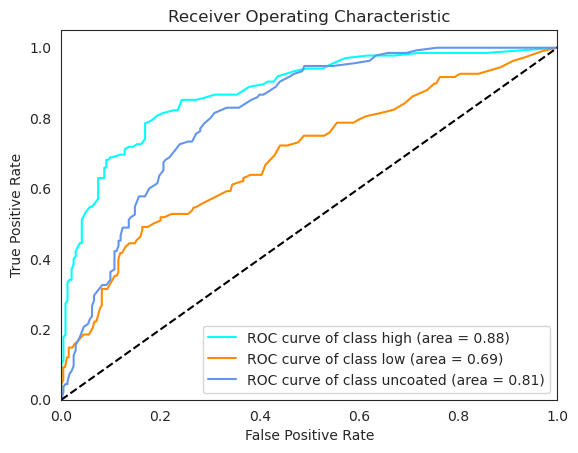

In [21]:
Gene_DF = MLGdb.drop(['unique_id', 'genome', 'Tube_ID'], axis=1)

# Separate the features (X) from the target variable (y)
X = Gene_DF.drop(['IgA_binding_class'], axis=1)
y = Gene_DF['IgA_binding_class']

display(X.head())

# Before splitting data
X_resampled, y_resampled = handle_class_imbalance(X, y, method='undersample')  # or 'oversample', 'combined'

# Then split your data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")

plot_confusion_matrix(y_test, y_pred, classes=clf.classes_)
plot_roc_curve(y_test, y_score, classes=clf.classes_)


## Test taxonomy classifier

,phylum_Actinobacteriota,phylum_Bacteroidota,phylum_Cyanobacteria,phylum_Desulfobacterota,phylum_Firmicutes,phylum_Firmicutes_A,phylum_Firmicutes_B,phylum_Firmicutes_C,phylum_Methanobacteriota,phylum_Proteobacteria,phylum_Thermoplasmatota,phylum_Verrucomicrobiota,class_Actinomycetia,class_Alphaproteobacteria,class_Bacilli,class_Bacteroidia,class_Clostridia,class_Clostridia_A,class_Coriobacteriia,class_Desulfovibrionia,class_Gammaproteobacteria,class_Methanobacteria,class_Negativicutes,class_Peptococcia,class_Thermoplasmata,class_Vampirovibrionia,class_Verrucomicrobiae,order_Acholeplasmatales,order_Acidaminococcales,order_Actinomycetales,order_Bacteroidales,order_Burkholderiales,order_Christensenellales,order_Coriobacteriales,order_Desulfovibrionales,order_Enterobacterales,order_Erysipelotrichales,order_Eubacteriales,order_Flavobacteriales,order_Gastranaerophilales,order_HGM11514,order_Lachnospirales,order_Lactobacillales,order_Methanobacteriales,order_Methanomassiliicoccales,order_Monoglobales,order_Monoglobales_A,order_Oscillospirales,order_Peptococcales,order_Peptostreptococcales,...,species_UMGS1338 sp900550805,species_UMGS1370 sp900542035,species_UMGS1375 sp900066615,species_UMGS1472 sp900552095,species_UMGS1484 sp900552285,species_UMGS1537 sp900543695,species_UMGS1540 sp900552775,species_UMGS1590 sp900552455,species_UMGS1600 sp900553295,species_UMGS1600 sp900553315,species_UMGS1603 sp900553265,species_UMGS1633 sp900553645,species_UMGS1663 sp900553865,species_UMGS1670 sp900548595,species_UMGS1670 sp902406135,species_UMGS172 sp900539855,species_UMGS1766 sp900554855,species_UMGS1783 sp900555065,species_UMGS1820 sp900545865,species_UMGS1826 sp900555435,species_UMGS1865 sp900555785,species_UMGS1872 sp900555795,species_UMGS1901 sp900553755,species_UMGS1933 sp900772235,species_UMGS1975 sp900546685,species_UMGS1975 sp900556815,species_UMGS1975 sp900751745,species_UMGS363 sp900768245,species_UMGS416 sp900542005,species_UMGS743 sp900545085,species_UMGS856 sp900546265,species_UMGS856 sp900760305,species_UMGS874 sp900546315,species_UMGS882 sp900757905,species_UMGS902 sp003343845,species_UMGS905 sp900540085,species_UMGS911 sp003343545,species_UMGS911 sp900545935,species_UMGS966 sp900547185,species_UMGS973 sp900547295,species_UMGS995 sp900547465,species_V9D3004 sp900760345,species_Varibaculum timonense,species_Veillonella atypica,species_Veillonella dispar_A,species_Veillonella parvula_A,species_Veillonella rogosae,species_Veillonella sp900757715,species_Zag1 sp000438175,species_unk
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Model accuracy: 0.6190476190476191


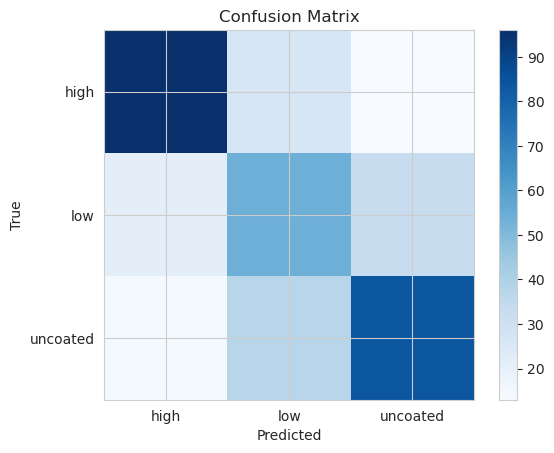

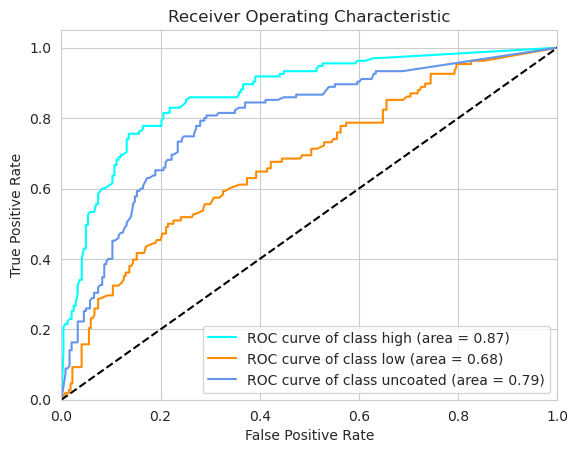

In [8]:
taxonomy_columns = ['phylum', 'class', 'order', 'family', 'genus', 'species']
TAX_df = one_hot_encode(MLdb, taxonomy_columns).drop(['genome', 'Tube_ID'], axis=1)

X = TAX_df.drop(['IgA_binding_class'], axis=1)
y = TAX_df['IgA_binding_class']

display(X.head())

# Before splitting data
X_resampled, y_resampled = handle_class_imbalance(X, y, method='undersample')  # or 'oversample', 'combined'

# Then split your data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")

plot_confusion_matrix(y_test, y_pred, classes=clf.classes_)
plot_roc_curve(y_test, y_score, classes=clf.classes_)


## Test Combined

In [9]:
# Taxonomy
db = MLdb.copy()
db['unique_id'] = db['genome'] + '|||' + db['Tube_ID'].astype(str)
taxonomy_columns = ['phylum', 'class', 'order', 'family', 'genus', 'species']
Tdb = one_hot_encode(db, taxonomy_columns).drop(['genome', 'Tube_ID'], axis=1)

# Genes
df = MLGdb.copy().drop(['genome', 'Tube_ID'], axis=1)

# Merge
MGCdb = pd.merge(Tdb, df, on=['unique_id', 'IgA_binding_class'], how='inner')
MGCdb


,IgA_binding_class,unique_id,phylum_Actinobacteriota,phylum_Bacteroidota,phylum_Cyanobacteria,phylum_Desulfobacterota,phylum_Firmicutes,phylum_Firmicutes_A,phylum_Firmicutes_B,phylum_Firmicutes_C,phylum_Methanobacteriota,phylum_Proteobacteria,phylum_Thermoplasmatota,phylum_Verrucomicrobiota,class_Actinomycetia,class_Alphaproteobacteria,class_Bacilli,class_Bacteroidia,class_Clostridia,class_Clostridia_A,class_Coriobacteriia,class_Desulfovibrionia,class_Gammaproteobacteria,class_Methanobacteria,class_Negativicutes,class_Peptococcia,class_Thermoplasmata,class_Vampirovibrionia,class_Verrucomicrobiae,order_Acholeplasmatales,order_Acidaminococcales,order_Actinomycetales,order_Bacteroidales,order_Burkholderiales,order_Christensenellales,order_Coriobacteriales,order_Desulfovibrionales,order_Enterobacterales,order_Erysipelotrichales,order_Eubacteriales,order_Flavobacteriales,order_Gastranaerophilales,order_HGM11514,order_Lachnospirales,order_Lactobacillales,order_Methanobacteriales,order_Methanomassiliicoccales,order_Monoglobales,order_Monoglobales_A,order_Oscillospirales,...,tRNA_deacylase,tRNA_edit,tRNA_int_endo,tRNA_int_endo_N,tRNA_m1G_MT,tRNA_synt_2f,tRNA_synthFbeta,ubiquitin,vATP-synt_AC39,vATP-synt_E,vWA-TerF-like,vWF_A,ydhR,zf-ACC,zf-C2H2_6,zf-C4_ClpX,zf-C4_Topoisom,zf-CCCH_2,zf-CCHC,zf-CDGSH,zf-CHC2,zf-CHCC,zf-CHY,zf-Di19,zf-FPG_IleRS,zf-HC2,zf-HYPF,zf-IS66,zf-ISL3,zf-MYND,zf-NADH-PPase,zf-RING_7,zf-RRN7,zf-RanBP,zf-Sec23_Sec24,zf-TFIIB,zf-TRM13_CCCH,zf-ZPR1,zf-dskA_traR,zf-like,zf-ribbon_3,zf-trcl,zf_CopZ,zinc-ribbons_6,zinc_ribbon_13,zinc_ribbon_15,zinc_ribbon_2,zinc_ribbon_4,zinc_ribbon_5,zn-ribbon_14
0,high,GUT_GENOME000139.fna.fa|||7028,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,high,GUT_GENOME000767.fna.fa|||7028,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,low,GUT_GENOME094675.fna.fa|||7028,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,low,GUT_GENOME096206.fna.fa|||7028,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,low,GUT_GENOME096538.fna.fa|||7028,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3514,uncoated,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0
3515,uncoated,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,1,0,1,0,1,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3516,uncoated,METABAT215_SUBJECTMAPPING_SCAFFOLDS_min1500_CO...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

,phylum_Actinobacteriota,phylum_Bacteroidota,phylum_Cyanobacteria,phylum_Desulfobacterota,phylum_Firmicutes,phylum_Firmicutes_A,phylum_Firmicutes_B,phylum_Firmicutes_C,phylum_Methanobacteriota,phylum_Proteobacteria,phylum_Thermoplasmatota,phylum_Verrucomicrobiota,class_Actinomycetia,class_Alphaproteobacteria,class_Bacilli,class_Bacteroidia,class_Clostridia,class_Clostridia_A,class_Coriobacteriia,class_Desulfovibrionia,class_Gammaproteobacteria,class_Methanobacteria,class_Negativicutes,class_Peptococcia,class_Thermoplasmata,class_Vampirovibrionia,class_Verrucomicrobiae,order_Acholeplasmatales,order_Acidaminococcales,order_Actinomycetales,order_Bacteroidales,order_Burkholderiales,order_Christensenellales,order_Coriobacteriales,order_Desulfovibrionales,order_Enterobacterales,order_Erysipelotrichales,order_Eubacteriales,order_Flavobacteriales,order_Gastranaerophilales,order_HGM11514,order_Lachnospirales,order_Lactobacillales,order_Methanobacteriales,order_Methanomassiliicoccales,order_Monoglobales,order_Monoglobales_A,order_Oscillospirales,order_Peptococcales,order_Peptostreptococcales,...,tRNA_deacylase,tRNA_edit,tRNA_int_endo,tRNA_int_endo_N,tRNA_m1G_MT,tRNA_synt_2f,tRNA_synthFbeta,ubiquitin,vATP-synt_AC39,vATP-synt_E,vWA-TerF-like,vWF_A,ydhR,zf-ACC,zf-C2H2_6,zf-C4_ClpX,zf-C4_Topoisom,zf-CCCH_2,zf-CCHC,zf-CDGSH,zf-CHC2,zf-CHCC,zf-CHY,zf-Di19,zf-FPG_IleRS,zf-HC2,zf-HYPF,zf-IS66,zf-ISL3,zf-MYND,zf-NADH-PPase,zf-RING_7,zf-RRN7,zf-RanBP,zf-Sec23_Sec24,zf-TFIIB,zf-TRM13_CCCH,zf-ZPR1,zf-dskA_traR,zf-like,zf-ribbon_3,zf-trcl,zf_CopZ,zinc-ribbons_6,zinc_ribbon_13,zinc_ribbon_15,zinc_ribbon_2,zinc_ribbon_4,zinc_ribbon_5,zn-ribbon_14
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


Model accuracy: 0.6243386243386243


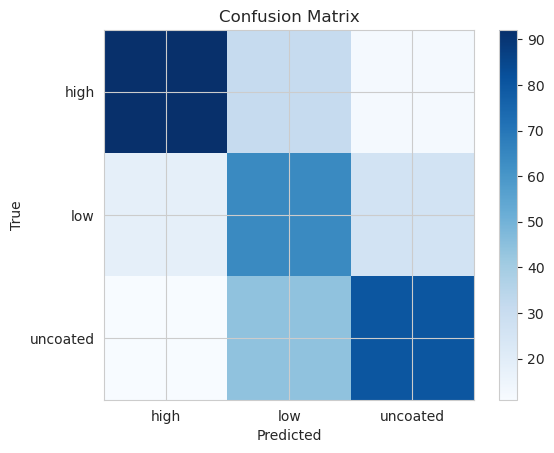

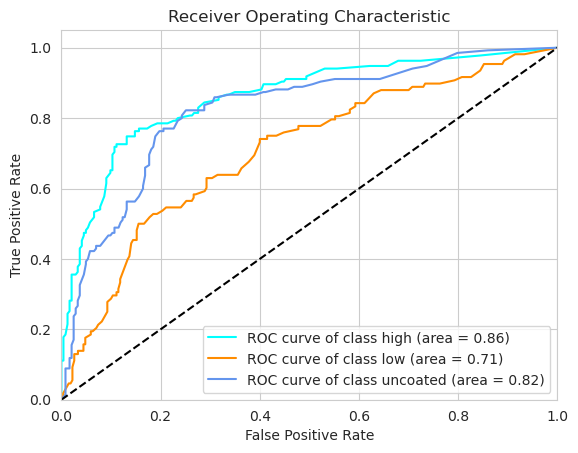

In [10]:
Both_df = MGCdb.drop(['unique_id'], axis=1)

X = Both_df.drop(['IgA_binding_class'], axis=1)
y = Both_df['IgA_binding_class']

display(X.head())

# Before splitting data
X_resampled, y_resampled = handle_class_imbalance(X, y, method='undersample')  # or 'oversample', 'combined'

# Then split your data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")

plot_confusion_matrix(y_test, y_pred, classes=clf.classes_)
plot_roc_curve(y_test, y_score, classes=clf.classes_)


# Train lots of them

In [11]:
from tqdm import tqdm
import random

# Function to train and evaluate
def train_and_evaluate(X, y, num_runs=100):
    accuracies = []
    for _ in tqdm(range(num_runs)):
        random_state = random.randint(0, 100000)
        X_resampled, y_resampled = handle_class_imbalance(X, y, method='undersample',random_state=random_state)
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=random_state)
        clf = RandomForestClassifier(random_state=random_state)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    return accuracies


In [ ]:
N = 100

# Evaluate genes
print("Evaluating using genes:")
X = Gene_DF.drop(['IgA_binding_class'], axis=1)
y = Gene_DF['IgA_binding_class']
gene_accuracies = train_and_evaluate(X, y, num_runs=N)
print(f"Accuracies using genes: {gene_accuracies}")

# Evaluate taxonomy
print("Evaluating using taxonomy:")
X = TAX_df.drop(['IgA_binding_class'], axis=1)
y = TAX_df['IgA_binding_class']
tax_accuracies = train_and_evaluate(X, y, num_runs=N)
print(f"Accuracies using taxonomy: {tax_accuracies}")

# Evaluate both
print("Evaluating using both:")
X = Both_df.drop(['IgA_binding_class'], axis=1)
y = Both_df['IgA_binding_class']
both_accuracies = train_and_evaluate(X, y, num_runs=N)
print(f"Accuracies using both: {both_accuracies}")


Evaluating using genes:


 89%|██████████████████████████████████████████████████████████████████████████████████████▎          | 89/100 [11:48<01:26,  7.88s/it]

## Plot

In [ ]:
# Create a DataFrame
data = {
    'Accuracy': both_accuracies + gene_accuracies + tax_accuracies,
    'Type': ['Both'] * len(both_accuracies) + ['Genes'] * len(gene_accuracies) + ['Taxonomy'] * len(tax_accuracies)
}

df = pd.DataFrame(data)
df.to_csv(dataloc + 'ML_accuracies_v4.csv', index=False)


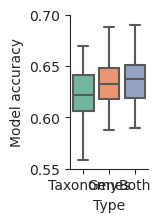

In [26]:
figloc = '/LAB_DATA/CURRENT/CURRENT_Metagenomics_PROJECTS/2021_IgASeq/figures_exmatch/'

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

    sns.set_style('white')
sns.boxplot(x='Type', y='Accuracy', data=df, order=['Taxonomy', 'Genes', 'Both'], showfliers=False)
#plt.title('Model Accuracy Comparison')
plt.ylabel('Model accuracy')


plt.gcf().set_size_inches(1, 2)
simpleaxis(plt.gca())

plt.ylim(0.55, 0.70)
plt.gcf().savefig(figloc + f"ML_accuracies_v2.2.pdf", bbox_inches='tight', dpi=300)
plt.show()


In [16]:
# Run a statistical test (two-sample t-test)
t_stat, p_value = scipy.stats.ranksums(both_accuracies, gene_accuracies)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

t_stat, p_value = scipy.stats.ranksums(tax_accuracies, gene_accuracies)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

t_stat, p_value = scipy.stats.ranksums(tax_accuracies, both_accuracies)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: 1.02866672148009, p-value: 0.30363631297896343
t-statistic: -3.016363581157176, p-value: 0.002558263037242641
t-statistic: -3.762818886174201, p-value: 0.00016800887583792425
